In [1]:
pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adhabib","key":"f42c096a5cc00f53d92a24965e9f9277"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c cs-480-2024-spring

 97% 277M/287M [00:02<00:00, 157MB/s]
100% 287M/287M [00:02<00:00, 114MB/s]


In [7]:
!unzip cs-480-2024-spring.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train_images/196207162.jpeg  
  inflating: data/train_images/196207164.jpeg  
  inflating: data/train_images/196207198.jpeg  
  inflating: data/train_images/196207403.jpeg  
  inflating: data/train_images/196207539.jpeg  
  inflating: data/train_images/196207572.jpeg  
  inflating: data/train_images/196207729.jpeg  
  inflating: data/train_images/196207888.jpeg  
  inflating: data/train_images/196208355.jpeg  
  inflating: data/train_images/196208682.jpeg  
  inflating: data/train_images/196208848.jpeg  
  inflating: data/train_images/196209074.jpeg  
  inflating: data/train_images/196209078.jpeg  
  inflating: data/train_images/196209236.jpeg  
  inflating: data/train_images/196209887.jpeg  
  inflating: data/train_images/196209889.jpeg  
  inflating: data/train_images/196209960.jpeg  
  inflating: data/train_images/196210323.jpeg  
  inflating: data/train_images/196211220.jpeg  
  inflating: data/train_images/196211

In [8]:
import random
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from PIL import Image
import os

In [9]:
train_data = pd.read_csv('/content/data/train.csv')
test_data = pd.read_csv('/content/data/test.csv')

# Sample 10% of the data
# train_data_sample = train_data
# test_data_sample = test_data
train_data_sample = train_data.sample(frac=1.0, random_state=42)
test_data_sample = test_data

# Target Traits:

# X4 - Stem Specific Density (SSD) or Wood Density
  Describes the density of the stem or wood, measured as stem dry mass per stem fresh volume.
# X11 - Leaf Area per Leaf Dry Mass
  Also known as specific leaf area (SLA) or 1/LMA (Leaf Mass per Area). This trait measures the area of a leaf relative to its dry mass.
# X18 - Plant Height
  The height of the plant, which is a straightforward measurement of the plant's size.
# X26 - Seed Dry Mass
  The dry mass of seeds, which is a measure of seed size and weight after all water has been removed.
# X50 - Leaf Nitrogen Content per Leaf Area
  The amount of nitrogen contained in leaves per unit area, indicating the nutritional content and photosynthetic capacity of the leaves.
# X3112 - Leaf Area (with Specific Consideration for Compound Leaves)
  This trait measures the area of a leaf, with the note that in the case of compound leaves, it may be unclear whether petioles are included or excluded.


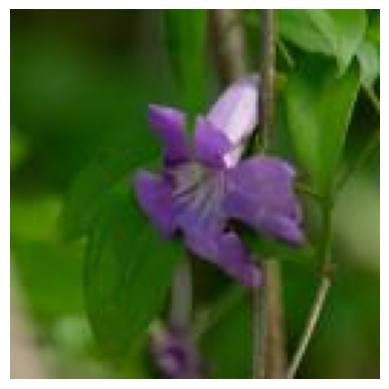

In [10]:
# Define the path to the image folder and a specific image file
image_folder = '/content/data/train_images'  # Update this with your path
image_id = '100010249'  # Replace with a specific ID from your dataset
image_path = os.path.join(image_folder, image_id + '.jpeg')

# Open and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

# Images are of size (128, 128, 3)

# Data Exploration / Preprocessing

In [11]:
# Import libraries
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import xgboost as xgb
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.metrics import r2_score
from tqdm import tqdm

In [12]:
## REMOVING OUTLIERS

# Separate the target columns in the training data
target_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']
feature_columns = [col for col in train_data_sample.columns if col not in target_columns + ['id']]

ancillary_train_id = pd.DataFrame(train_data_sample['id'])
ancillary_test_id = pd.DataFrame(test_data_sample['id'])

ancillary_train_features = train_data_sample[feature_columns]
ancillary_test_features = test_data_sample[feature_columns]

# # Log Transform
# ancillary_train_features = ancillary_train_features.apply(lambda x: np.log1p(x - x.min() + 1))
# ancillary_test_features = ancillary_test_features.apply(lambda x: np.log1p(x - x.min() + 1))

# Apply z-score normalization
scaler = StandardScaler()
ancillary_train_normalized = scaler.fit_transform(ancillary_train_features)
ancillary_test_normalized = scaler.transform(ancillary_test_features)

# Convert back to DataFrame
ancillary_train = pd.DataFrame(ancillary_train_normalized, columns=feature_columns, index=train_data_sample.index)
ancillary_test = pd.DataFrame(ancillary_test_normalized, columns=feature_columns, index=test_data_sample.index)
print(len(ancillary_train))

# Filter out rows with any z-score exceeding the threshold of 4
threshold = 4
mask = (ancillary_train.abs() < threshold).all(axis=1)
ancillary_train = ancillary_train[mask]

# Also filter corresponding rows in target columns and ID column
ancillary_train_id = ancillary_train_id[mask]
y_train = train_data_sample.loc[mask, target_columns]

# Add the 'id' column back
ancillary_train['id'] = ancillary_train_id
ancillary_test['id'] = ancillary_test_id


# Normalize target columns separately
# y_train = y_train.apply(lambda x: np.log1p(x - x.min() + 1))

target_scaler = StandardScaler()
y_train_normalized = target_scaler.fit_transform(y_train)
y_train_normalized = pd.DataFrame(y_train_normalized, columns=target_columns, index=y_train.index)

# Add the target columns back to the filtered training set
ancillary_train[target_columns] = y_train_normalized

43363


<ipython-input-12-ffdac6e5b306>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancillary_train['id'] = ancillary_train_id
<ipython-input-12-ffdac6e5b306>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancillary_train[target_columns] = y_train_normalized
<ipython-input-12-ffdac6e5b306>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
ancillary_train

,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,id,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
7861,0.272098,0.450258,0.611822,0.356528,0.511071,0.044185,-0.169845,-0.309890,0.162869,-0.089366,...,1.957163,2.299404,2.341051,18388750,1.216526,-0.219565,1.192605,1.417378,-0.279785,0.488554
1034,-0.734674,0.632800,-0.244635,-0.901852,0.549467,0.243318,-0.339350,-0.042622,-0.272888,-0.153602,...,1.125551,0.929911,0.617073,196383353,-2.019086,0.097947,-0.370669,-0.332354,-0.776093,-0.677131
21528,-1.305186,0.523742,-0.612094,-1.316821,0.331948,-0.024384,-1.243378,0.024195,-1.206653,-0.474779,...,1.148283,0.969898,0.430262,195496059,1.467298,0.088841,-0.599187,-0.342014,-1.476597,-0.614042
4962,1.707158,0.815478,1.874339,1.549051,-1.109947,-0.798726,0.734182,-0.643975,0.225120,-0.410544,...,-0.668223,-0.627900,-0.588132,165484930,-0.236446,-0.832029,-0.532806,-0.342456,-1.362777,-0.697957
4283,0.024178,-0.834980,-0.706061,-0.520146,0.530540,0.562078,0.903687,0.625547,0.909881,0.745695,...,-0.924829,-0.804704,-0.751690,194642074,-0.203816,1.226688,-0.588816,-0.331835,-0.100593,-0.532627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.154338,-0.317736,-0.273294,-0.147015,-0.716428,-0.864687,-0.508855,-0.042622,-0.397390,-0.153602,...,-0.716755,-0.744235,-0.790109,192047767,1.062102,-1.539833,-0.283435,-0.270858,0.770019,-0.611419
11284,1.566032,2.174772,1.720775,-0.273144,-1.507868,-1.668612,-0.791364,-0.443524,-0.895398,-0.795957,...,-0.219050,-0.166385,-0.113503,140018028,0.489039,0.701209,-0.243543,0.243643,0.080521,1.756192
38158,0.155030,-0.386886,-0.332423,-0.146976,-0.670952,-0.777426,-0.226347,0.024195,-0.086135,0.039104,...,-0.564809,-0.581108,-0.649893,184470019,0.933050,-1.362093,-0.397713,0.103039,-0.179131,-0.618978
860,-0.261877,0.019074,-0.336937,-0.733411,1.463610,1.547192,1.016691,2.095520,1.719144,2.030404,...,0.621155,0.367435,0.311690,196704567,-0.800264,0.215259,-0.445017,-0.337011,-0.995448,-0.160025


In [13]:
import pandas as pd

# Calculate the correlation matrix between the features and the targets
correlation_matrix = ancillary_train.corr()

# Extract correlations between features and each target variable
target_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']
correlations = correlation_matrix[target_columns].drop(target_columns)

# Sort correlations from highest to lowest for each target
sorted_correlations = {}
for target in target_columns:
    sorted_correlations[target] = correlations[target].abs().sort_values(ascending=False)

# Combine the sorted correlations into a single DataFrame for easier viewing
sorted_correlations_df = pd.concat(sorted_correlations, axis=1)

# Calculate the average absolute correlation for each feature
sorted_correlations_df['Average_Correlation'] = sorted_correlations_df.mean(axis=1)

# Sort the DataFrame by the new 'Average_Correlation' column in descending order
sorted_correlations_df = sorted_correlations_df.sort_values(by='Average_Correlation', ascending=False)

# Display the sorted correlation matrix with the new column
sorted_correlations_df


,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean,Average_Correlation
WORLDCLIM_BIO1_annual_mean_temperature,0.277047,0.176876,0.335129,0.263028,0.098267,0.276181,0.237755
WORLDCLIM_BIO4_temperature_seasonality,0.248496,0.190666,0.291653,0.212503,0.072627,0.239998,0.209324
WORLDCLIM_BIO12_annual_precipitation,0.086861,0.037184,0.350153,0.225901,0.141476,0.355390,0.199494
WORLDCLIM_BIO7_temperature_annual_range,0.224317,0.148326,0.300982,0.211334,0.026248,0.252444,0.193942
WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,0.124349,0.008108,0.324506,0.236287,0.078120,0.318705,0.181679
...,...,...,...,...,...,...,...
MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1,0.092838,0.068220,0.044772,0.004770,0.011837,0.006344,0.038130
SOIL_soc_30.60cm_mean_0.01_deg,0.043818,0.043425,0.023706,0.019052,0.074408,0.012861,0.036212
MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12,0.049113,0.024671,0.009498,0.038413,0.013293,0.043266,0.029709
SOIL_soc_60.100cm_mean_0.01_deg,0.023398,0.020552,0.026395,0.013197,0.051083,0.006445,0.023512


In [14]:
threshold = 0.04

# Filter features with an average correlation above the threshold
filtered_features = sorted_correlations_df[sorted_correlations_df['Average_Correlation'] > threshold].index.tolist()

# Subset ancillary_train to keep only the filtered features
ancillary_train_subset = ancillary_train[filtered_features + target_columns]

# Display the first few rows of the filtered DataFrame
ancillary_train_subset.head()

,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO7_temperature_annual_range,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,SOIL_silt_30.60cm_mean_0.01_deg,SOIL_silt_0.5cm_mean_0.01_deg,SOIL_silt_5.15cm_mean_0.01_deg,SOIL_silt_15.30cm_mean_0.01_deg,SOIL_silt_60.100cm_mean_0.01_deg,...,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2,SOIL_bdod_5.15cm_mean_0.01_deg,SOIL_soc_15.30cm_mean_0.01_deg,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m5,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
7861,0.272098,0.511071,0.450258,0.044185,0.611822,1.135591,1.189500,1.274148,1.188385,1.237669,...,-1.024311,-0.196489,-0.311387,0.006009,1.216526,-0.219565,1.192605,1.417378,-0.279785,0.488554
1034,-0.734674,0.549467,0.632800,0.243318,-0.244635,1.351678,1.249461,1.248416,1.232392,1.293813,...,0.453274,-0.316100,0.341683,0.473565,-2.019086,0.097947,-0.370669,-0.332354,-0.776093,-0.677131
21528,-1.305186,0.331948,0.523742,-0.024384,-0.612094,1.045555,1.095274,1.076869,1.117975,1.153454,...,1.933087,-1.093575,1.019398,-0.762118,1.467298,0.088841,-0.599187,-0.342014,-1.476597,-0.614042
4962,1.707158,-1.109947,0.815478,-0.798726,1.874339,-0.620115,-0.583650,-0.595714,-0.615879,-0.568278,...,-0.201202,0.461375,-0.409964,0.120261,-0.236446,-0.832029,-0.532806,-0.342456,-1.362777,-0.697957
4283,0.024178,0.530540,-0.834980,0.562078,-0.706061,0.262240,0.427131,0.467877,0.325859,0.301945,...,-0.454523,1.119238,-0.590688,0.971002,-0.203816,1.226688,-0.588816,-0.331835,-0.100593,-0.532627


In [15]:

# Define the target columns
target_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']

# Extract the feature columns (excluding 'id' and target columns)
feature_columns = [col for col in ancillary_train_subset.columns if col not in target_columns + ['id']]

In [16]:
# Define the device to use (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the PlantDataset class
class PlantDataset(Dataset):
    def __init__(self, img_dir, df, transform=None):
        self.img_dir = img_dir
        self.df = df
        self.transform = transform
        self.df['id'] = self.df['id'].astype(str)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, str(self.df.iloc[idx]['id']) + '.jpeg')
        image = Image.open(img_name).convert("RGB")

        ancillary_features = self.df.iloc[idx][feature_columns].values.astype('float32')

        if self.transform:
            image = self.transform(image)

        return image, ancillary_features


class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNetFeatureExtractor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features_resnet = self.resnet.fc.in_features  # Get the number of input features of the last layer
        self.resnet.fc = nn.Identity()  # Remove the last fully connected layer

    def forward(self, x):
        x = self.resnet(x)  # Extract features using ResNet
        return x

# Initialize the ResNet feature extractor
resnet_feature_extractor = ResNetFeatureExtractor().to(device)



def extract_image_features(model, dataloader):
    model.eval()
    features_list = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            features = model(images)
            features_list.append(features.cpu().numpy())
    return np.vstack(features_list)

# Define transformations for the images
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the images
])

train_dataset = PlantDataset('/content/data/train_images', ancillary_train_subset, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = PlantDataset('/content/data/test_images', ancillary_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Extract image features
train_image_features = extract_image_features(resnet_feature_extractor, train_loader)
test_image_features = extract_image_features(resnet_feature_extractor, test_loader)

# Combine image features with ancillary features
X_train_combined = np.hstack((train_image_features, ancillary_train_subset[feature_columns].values))
X_test_combined = np.hstack((test_image_features, ancillary_test[feature_columns].values))

# Define target variables
y_train = ancillary_train_subset[target_columns]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 114MB/s]
<ipython-input-16-c2a00283749d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [17]:
# Define the hyperparameters for XGBoost
params = {
    'n_estimators': 200,
    'learning_rate': 0.02,
    'max_depth': 7,
    'objective': 'reg:squarederror',
    'n_jobs': -1
}

# XGBoost Only (Environmental Data Only)

In [ ]:
# Initialize a dictionary to store R2 scores and models
r2_scores = {}
models = {}

# Train an XGBoost Regressor for each target with a progress bar
for target in tqdm(target_columns, desc="Training models"):
    model = xgb.XGBRegressor(**params)
    model.fit(ancillary_train_subset[feature_columns], ancillary_train_subset[target])
    y_pred = model.predict(ancillary_train_subset[feature_columns])
    r2 = r2_score(ancillary_train_subset[target], y_pred)
    r2_scores[target] = r2
    models[target] = model  # Save the trained model for prediction
    print(f'R2 score for {target}: {r2:.4f}')

# Calculate and print the average R2 score
average_r2 = np.mean(list(r2_scores.values()))
print(f'Average R2 score: {average_r2:.4f}')


Training models:  17%|█▋        | 1/6 [00:26<02:10, 26.07s/it]

R2 score for X4_mean: 0.3282


Training models:  33%|███▎      | 2/6 [00:52<01:46, 26.57s/it]

R2 score for X11_mean: 0.3551


Training models:  50%|█████     | 3/6 [01:18<01:18, 26.12s/it]

R2 score for X18_mean: 0.4445


Training models:  67%|██████▋   | 4/6 [01:39<00:47, 23.90s/it]

R2 score for X26_mean: 0.3780


Training models:  83%|████████▎ | 5/6 [02:04<00:24, 24.52s/it]

R2 score for X50_mean: 0.2871


Training models: 100%|██████████| 6/6 [02:29<00:00, 24.89s/it]

R2 score for X3112_mean: 0.4384
Average R2 score: 0.3719


In [ ]:
# Make predictions on the test set
predictions = {}
for target in target_columns:
    model = models[target]
    predictions[target] = model.predict(ancillary_test[feature_columns])

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions, index=ancillary_test.index)

# Unnormalize the predictions
# Reverse the standardization
predictions_df = pd.DataFrame(target_scaler.inverse_transform(predictions_df), columns=target_columns, index=ancillary_test.index)


# Add the 'id' column back to the predictions DataFrame
predictions_df['id'] = ancillary_test['id']

# Prepare the submission file
submission = predictions_df[['id'] + target_columns]
submission.columns = ['id', 'X4', 'X11', 'X18', 'X26', 'X50', 'X3112']
submission.to_csv('submissionXGBoostOnly.csv', index=False)

print("Predictions and submission file created successfully.")

Predictions and submission file created successfully.


# XG Boost (Only Image Features)

In [ ]:
# Train XGBoost model on CNN features only
r2_scores = {}
models = {}

for target in tqdm(target_columns, desc="Training models"):
    model = xgb.XGBRegressor(**params)
    model.fit(train_image_features, y_train[target])
    y_pred = model.predict(train_image_features)
    r2 = r2_score(y_train[target], y_pred)
    r2_scores[target] = r2
    models[target] = model  # Save the trained model for prediction
    print(f'R2 score for {target}: {r2:.4f}')

Training models:  17%|█▋        | 1/6 [08:44<43:41, 524.22s/it]

R2 score for X4_mean: 0.3830


Training models:  33%|███▎      | 2/6 [17:26<34:53, 523.27s/it]

R2 score for X11_mean: 0.3936


Training models:  50%|█████     | 3/6 [25:37<25:24, 508.21s/it]

R2 score for X18_mean: 0.6199


Training models:  67%|██████▋   | 4/6 [32:37<15:47, 473.64s/it]

R2 score for X26_mean: 0.5652


Training models:  83%|████████▎ | 5/6 [41:02<08:05, 485.01s/it]

R2 score for X50_mean: 0.3555


Training models: 100%|██████████| 6/6 [49:12<00:00, 492.03s/it]

R2 score for X3112_mean: 0.5348


# CNN + Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

# Train Linear Regression model on combined CNN and ancillary features
r2_scores = {}
models = {}

for target in tqdm(target_columns, desc="Training models"):
    model = LinearRegression()
    model.fit(X_train_combined, y_train[target])
    y_pred = model.predict(X_train_combined)
    r2 = r2_score(y_train[target], y_pred)
    r2_scores[target] = r2
    models[target] = model  # Save the trained model for prediction
    print(f'R2 score for {target}: {r2:.4f}')


Training models:  17%|█▋        | 1/6 [00:26<02:13, 26.76s/it]

R2 score for X4_mean: 0.2822


Training models:  33%|███▎      | 2/6 [00:54<01:48, 27.05s/it]

R2 score for X11_mean: 0.2973


Training models:  50%|█████     | 3/6 [01:20<01:20, 26.89s/it]

R2 score for X18_mean: 0.4427


Training models:  67%|██████▋   | 4/6 [01:44<00:51, 25.82s/it]

R2 score for X26_mean: 0.2319


Training models:  83%|████████▎ | 5/6 [02:10<00:25, 25.71s/it]

R2 score for X50_mean: 0.2089


Training models: 100%|██████████| 6/6 [02:37<00:00, 26.29s/it]

R2 score for X3112_mean: 0.3411


# XGBoost (Ancillary Data + Image Features)


In [18]:
import xgboost as xgb


# Define the hyperparameters for XGBoost
params = {
    'n_estimators': 200,
    'learning_rate': 0.02,
    'max_depth': 7,
    'objective': 'reg:squarederror',
    'n_jobs': -1
}

# Initialize a dictionary to store R2 scores and models
r2_scores = {}
models = {}

# Train an XGBoost Regressor for each target with a progress bar
for target in tqdm(target_columns, desc="Training models"):
    model = xgb.XGBRegressor(**params)
    model.fit(X_train_combined, y_train[target])
    y_pred = model.predict(X_train_combined)
    r2 = r2_score(y_train[target], y_pred)
    r2_scores[target] = r2
    models[target] = model  # Save the trained model for prediction
    print(f'R2 score for {target}: {r2:.4f}')

# Calculate and print the average R2 score
average_r2 = np.mean(list(r2_scores.values()))
print(f'Average R2 score: {average_r2:.4f}')

# Make predictions on the test set
test_predictions = np.zeros((len(ancillary_test), len(target_columns)))
for i, target in enumerate(target_columns):
    test_predictions[:, i] = models[target].predict(X_test_combined)

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(test_predictions, columns=target_columns, index=ancillary_test.index)

# Unnormalize the predictions
# Reverse the standardization
predictions_df = pd.DataFrame(target_scaler.inverse_transform(predictions_df), columns=target_columns, index=ancillary_test.index)

# Add the 'id' column back to the predictions DataFrame
predictions_df['id'] = ancillary_test['id']

# Prepare the submission file
submission = predictions_df[['id'] + target_columns]
submission.columns = ['id', 'X4', 'X11', 'X18', 'X26', 'X50', 'X3112']
submission.to_csv('submission.csv', index=False)

print("Predictions and submission file created successfully.")

Training models:  17%|█▋        | 1/6 [09:23<46:58, 563.76s/it]

R2 score for X4_mean: 0.4670


Training models:  33%|███▎      | 2/6 [18:54<37:51, 567.98s/it]

R2 score for X11_mean: 0.4889


Training models:  50%|█████     | 3/6 [27:48<27:37, 552.52s/it]

R2 score for X18_mean: 0.6798


Training models:  67%|██████▋   | 4/6 [35:31<17:13, 516.93s/it]

R2 score for X26_mean: 0.6383


Training models:  83%|████████▎ | 5/6 [44:42<08:49, 529.25s/it]

R2 score for X50_mean: 0.4205


Training models: 100%|██████████| 6/6 [53:24<00:00, 534.05s/it]

R2 score for X3112_mean: 0.6088
Average R2 score: 0.5505


Predictions and submission file created successfully.


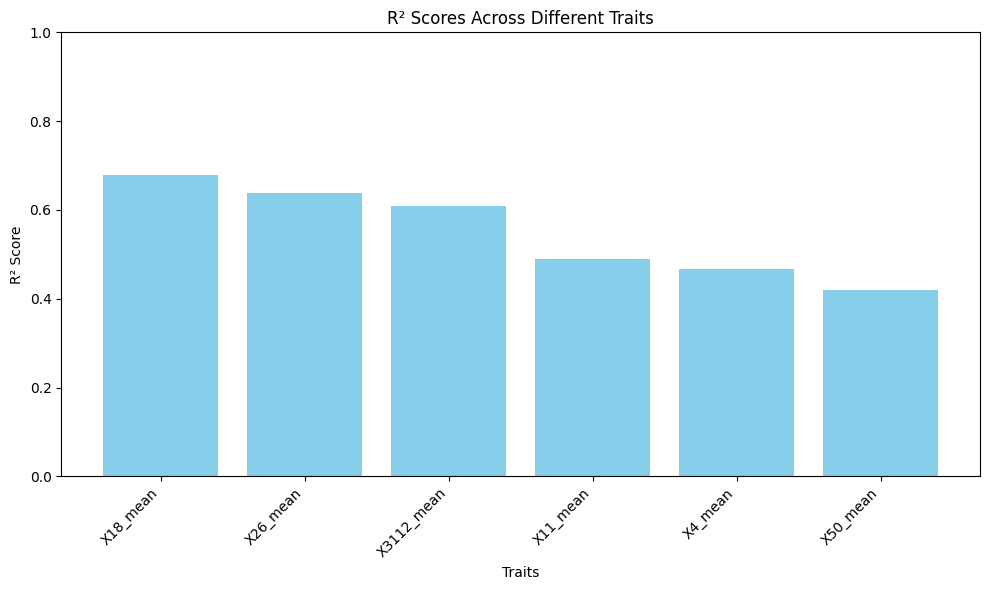

In [25]:
import matplotlib.pyplot as plt

# Assuming r2_scores is a dictionary with trait names as keys and R² scores as values

# Sort the R2 scores dictionary by values in descending order for better visualization
sorted_r2_scores = dict(sorted(r2_scores.items(), key=lambda item: item[1], reverse=True))

# Plotting the R² scores
plt.figure(figsize=(10, 6))
plt.bar(sorted_r2_scores.keys(), sorted_r2_scores.values(), color='skyblue')
plt.xlabel('Traits')
plt.ylabel('R² Score')
plt.title('R² Scores Across Different Traits')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # Assuming R² scores are within the range [0, 1]
plt.tight_layout()

# Display the plot
plt.show()


# CNN + Ancillary Data - Shallow Neural Network

In [ ]:
# import xgboost as xgb
# from sklearn.metrics import r2_score
# from tqdm import tqdm

# # Define the hyperparameters for XGBoost
# params = {
#     'n_estimators': 100,
#     'learning_rate': 0.02,
#     'max_depth': 5,
#     'objective': 'reg:squarederror',
#     'n_jobs': -1
# }

# # Initialize a dictionary to store R2 scores and models
# r2_scores = {}
# models = {}

# # Train an XGBoost Regressor for each target with a progress bar
# for target in tqdm(target_columns, desc="Training models"):
#     model = xgb.XGBRegressor(**params)
#     model.fit(X_train_combined, y_train[target])
#     y_pred = model.predict(X_train_combined)
#     r2 = r2_score(y_train[target], y_pred)
#     r2_scores[target] = r2
#     models[target] = model  # Save the trained model for prediction
#     print(f'R2 score for {target}: {r2:.4f}')

# # Calculate and print the average R2 score
# average_r2 = np.mean(list(r2_scores.values()))
# print(f'Average R2 score: {average_r2:.4f}')

# # Make predictions on the test set
# test_predictions = np.zeros((len(ancillary_test), len(target_columns)))
# for i, target in enumerate(target_columns):
#     test_predictions[:, i] = models[target].predict(X_test_combined)

# # Convert predictions to DataFrame
# predictions_df = pd.DataFrame(test_predictions, columns=target_columns, index=ancillary_test.index)

# # Unnormalize the predictions
# # Reverse the standardization
# predictions_df = pd.DataFrame(target_scaler.inverse_transform(predictions_df), columns=target_columns, index=ancillary_test.index)

# # Reverse the log transformation
# for col in predictions_df.columns:
#     min_value = ancillary_train_features[col].min()
#     predictions_df[col] = np.expm1(predictions_df[col]) + min_value

# # Add the 'id' column back to the predictions DataFrame
# predictions_df['id'] = ancillary_test['id']

# # Prepare the submission file
# submission = predictions_df[['id'] + target_columns]
# submission.columns = ['id', 'X4', 'X11', 'X18', 'X26', 'X50', 'X3112']
# submission.to_csv('submission.csv', index=False)

# print("Predictions and submission file created successfully.")


In [ ]:
# # Define transformations for images
# transform = transforms.Compose([
#     transforms.Resize((128, 128)), # 128x128 often retains enough detail for feature extraction, especially when using powerful CNNs like ResNet.
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # typical values used for the imagenet dataset
# ])

In [ ]:
# class PlantDatasetForExtraction(Dataset):
#     def __init__(self, img_dir, ancillary_data, transform=None):
#         self.img_dir = img_dir
#         self.ancillary_data = ancillary_data
#         self.transform = transform

#     def __len__(self):
#         return len(self.ancillary_data)

#     def __getitem__(self, idx):
#         img_id = self.ancillary_data.index[idx]
#         img_path = os.path.join(self.img_dir, f"{img_id}.jpeg")

#         if not os.path.exists(img_path):
#             print(f"Image file {img_path} not found, skipping.")
#             return self.__getitem__((idx + 1) % len(self.ancillary_data))

#         image = Image.open(img_path).convert("RGB")

#         if self.transform:
#             image = self.transform(image)

#         ancillary = torch.tensor(self.ancillary_data.iloc[idx].values, dtype=torch.float)
#         return image, ancillary

In [ ]:
# # Create datasets and data loaders for feature extraction

# valid_ids = ancillary_train_id[mask]  # Get the valid IDs after outlier removal
# ancillary_train_subset = ancillary_train_subset.set_index(valid_ids['id'])


# train_dataset_for_extraction = PlantDatasetForExtraction('/content/data/train_images', ancillary_train_subset, transform)
# test_dataset_for_extraction = PlantDatasetForExtraction('/content/data/test_images', pd.DataFrame(ancillary_test_subset, index=test_data_sample['id']), transform)

# train_loader_for_extraction = DataLoader(train_dataset_for_extraction, batch_size=32, shuffle=True)
# test_loader_for_extraction = DataLoader(test_dataset_for_extraction, batch_size=32, shuffle=False)


In [ ]:
test_predictions.shape

(3196, 6)